In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
sys.path.append('.')

## 1. Carregar Dados Processados

In [5]:
# Carregar dados processados (já padronizados)
XTrain = pd.read_csv('dados_processados/XTrain.csv')
XTest = pd.read_csv('dados_processados/XTest.csv')
YTrain = pd.read_csv('dados_processados/YTrain.csv').values.flatten()  # Flatten para 1D
YTest = pd.read_csv('dados_processados/YTest.csv').values.flatten()    # Flatten para 1D

# Converter para numpy arrays
X_train = XTrain.values
X_test = XTest.values

# Reshape Y para formato coluna (n, 1) para compatibilidade com rede neural
YTrain = YTrain.reshape(-1, 1)
YTest = YTest.reshape(-1, 1)

print(f"✅ Dados carregados com sucesso!")
print(f"\n📊 Dimensões:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   Y_train: {YTrain.shape}")
print(f"   Y_test: {YTest.shape}")
print(f"\n📝 Features ({X_train.shape[1]}):")
print(f"   {list(XTrain.columns)}")

✅ Dados carregados com sucesso!

📊 Dimensões:
   X_train: (295431, 35)
   X_test: (73858, 35)
   Y_train: (295431, 1)
   Y_test: (73858, 1)

📝 Features (35):
   ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'SD1', 'SD2', 'sampen', 'higuci', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF', 'condition_no stress', 'condition_time pressure']


## 2. Importar a Rede Neural

In [3]:
import os

# Verificar se o arquivo existe
arquivo_path = 'neural_network.py'
if os.path.exists(arquivo_path):
    print(f"✅ Arquivo '{arquivo_path}' encontrado")
    print(f"   Caminho absoluto: {os.path.abspath(arquivo_path)}")
    print(f"   Tamanho: {os.path.getsize(arquivo_path)} bytes")
else:
    print(f"❌ Arquivo '{arquivo_path}' NÃO encontrado")
    print(f"   Diretório atual: {os.getcwd()}")
    print(f"   Arquivos disponíveis: {os.listdir('.')}")

✅ Arquivo 'neural_network.py' encontrado
   Caminho absoluto: /home/kauar/ica-homeworks/neural_network.py
   Tamanho: 7499 bytes


In [4]:
# Limpar cache do Python e importar
import importlib
import sys

# Remover do cache se já foi importado
if 'neural_network' in sys.modules:
    del sys.modules['neural_network']

# Importar a classe
from neural_network import NeuralNetworkRegression

print("✅ Classe NeuralNetworkRegression importada com sucesso!")
print(f"   Classe: {NeuralNetworkRegression}")
print(f"   Módulo: {NeuralNetworkRegression.__module__}")

✅ Classe NeuralNetworkRegression importada com sucesso!
   Classe: <class 'neural_network.NeuralNetworkRegression'>
   Módulo: neural_network


## 3. Criar e Configurar o Modelo

## 3.1. Validação para Encontrar Melhores Hiperparâmetros

In [6]:
# Validação: Encontrar melhores hiperparâmetros usando Grid Search
from sklearn.model_selection import train_test_split

# Dividir o conjunto de treino em treino e validação (80/20)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, YTrain, test_size=0.2, random_state=27
)

print("🔍 VALIDAÇÃO: BUSCA DE MELHORES HIPERPARÂMETROS")
print("="*70)
print(f"\nDados de validação:")
print(f"   Treino split: {X_train_split.shape}")
print(f"   Validação split: {X_val_split.shape}")

# Grid de hiperparâmetros para testar (reduzido para velocidade)
hidden_sizes = [32, 64, 128]
learning_rates = [0.001, 0.01]  # Removido 0.05
weight_decays = [0.0, 0.001]    # Removido 0.01

# Parâmetros fixos
epochs_val = 300  # Reduzido para 300 épocas (validação rápida)
num_tests = len(hidden_sizes) * len(learning_rates) * len(weight_decays)

print(f"\n🔬 Testando {num_tests} combinações de hiperparâmetros...")
print(f"   Hidden sizes: {hidden_sizes}")
print(f"   Learning rates: {learning_rates}")
print(f"   Weight decays: {weight_decays}")
print("="*70)

# Armazenar resultados
resultados = []
melhor_r2 = -np.inf
melhor_config = None

contador = 0
for hidden in hidden_sizes:
    for lr in learning_rates:
        for wd in weight_decays:
            contador += 1
            
            # Criar modelo com estes hiperparâmetros
            modelo_temp = NeuralNetworkRegression(
                input_size=X_train.shape[1],
                hidden_size=hidden,
                output_size=1,
                weight_decay=wd
            )
            
            # Treinar (silenciosamente)
            modelo_temp.train(X_train_split, y_train_split, epochs=epochs_val, learning_rate=lr)
            
            # Avaliar na validação
            y_val_pred = modelo_temp.forward(X_val_split)
            val_r2 = r2_score(y_val_split, y_val_pred)
            val_rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))
            
            # Guardar resultado
            resultados.append({
                'hidden_size': hidden,
                'learning_rate': lr,
                'weight_decay': wd,
                'val_r2': val_r2,
                'val_rmse': val_rmse
            })
            
            # Atualizar melhor configuração
            if val_r2 > melhor_r2:
                melhor_r2 = val_r2
                melhor_config = {
                    'hidden_size': hidden,
                    'learning_rate': lr,
                    'weight_decay': wd
                }
            
            # Progresso
            print(f"[{contador}/{num_tests}] Hidden={hidden}, LR={lr}, WD={wd} → R² Val: {val_r2:.6f}, RMSE Val: {val_rmse:.6f}")

# Ordenar resultados por R² (melhor primeiro)
resultados_df = pd.DataFrame(resultados).sort_values('val_r2', ascending=False)

print("\n" + "="*70)
print("📊 TOP 5 MELHORES CONFIGURAÇÕES:")
print("="*70)
print(resultados_df.head(5).to_string(index=False))

print("\n" + "="*70)
print("🏆 MELHOR CONFIGURAÇÃO ENCONTRADA:")
print("="*70)
print(f"   Hidden Size: {melhor_config['hidden_size']}")
print(f"   Learning Rate: {melhor_config['learning_rate']}")
print(f"   Weight Decay: {melhor_config['weight_decay']}")
print(f"   R² Validação: {melhor_r2:.6f}")
print("="*70)

🔍 VALIDAÇÃO: BUSCA DE MELHORES HIPERPARÂMETROS

Dados de validação:
   Treino split: (236344, 35)
   Validação split: (59087, 35)

🔬 Testando 12 combinações de hiperparâmetros...
   Hidden sizes: [32, 64, 128]
   Learning rates: [0.001, 0.01]
   Weight decays: [0.0, 0.001]
Epoch 0, Loss (MSE): 5587.6798
Epoch 0, Loss (MSE): 5587.6798
[1/12] Hidden=32, LR=0.001, WD=0.0 → R² Val: 0.788445, RMSE Val: 4.761867
[1/12] Hidden=32, LR=0.001, WD=0.0 → R² Val: 0.788445, RMSE Val: 4.761867
Epoch 0, Loss (MSE): 5570.4491
Epoch 0, Loss (MSE): 5570.4491
[2/12] Hidden=32, LR=0.001, WD=0.001 → R² Val: 0.792816, RMSE Val: 4.712420
[2/12] Hidden=32, LR=0.001, WD=0.001 → R² Val: 0.792816, RMSE Val: 4.712420
Epoch 0, Loss (MSE): 5750.2616
Epoch 0, Loss (MSE): 5750.2616
[3/12] Hidden=32, LR=0.01, WD=0.0 → R² Val: 0.962833, RMSE Val: 1.995917
[3/12] Hidden=32, LR=0.01, WD=0.0 → R² Val: 0.962833, RMSE Val: 1.995917
Epoch 0, Loss (MSE): 5558.9765
Epoch 0, Loss (MSE): 5558.9765
[4/12] Hidden=32, LR=0.01, WD=0.

In [9]:
# Parâmetros do modelo
input_size = X_train.shape[1]      # Número de features
hidden_size = 128                  # Neurônios na camada oculta
output_size = 1                    # Regressão (1 saída)
weight_decay = 0.0                 # Regularização L2
learning_rate = 0.01               # Taxa de aprendizado
epochs = 2000                      # Número de épocas

# Criar modelo
model = NeuralNetworkRegression(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    weight_decay=weight_decay
)

print(f"✅ Modelo criado com sucesso!")
print(f"\n🏗️ Arquitetura:")
print(f"   Camada de entrada: {input_size} neurônios")
print(f"   Camada oculta: {hidden_size} neurônios (Sigmoide)")
print(f"   Camada de saída: {output_size} neurônio (Linear)")
print(f"   Regularização L2: {weight_decay}")

✅ Modelo criado com sucesso!

🏗️ Arquitetura:
   Camada de entrada: 35 neurônios
   Camada oculta: 128 neurônios (Sigmoide)
   Camada de saída: 1 neurônio (Linear)
   Regularização L2: 0.0


## 4. Treinar o Modelo

In [10]:
print(f"🚀 Iniciando treinamento...\n")

loss_history = model.train(
    X_train, 
    YTrain, 
    epochs=epochs, 
    learning_rate=learning_rate
)

print(f"\n✅ Treinamento concluído!")

🚀 Iniciando treinamento...

Epoch 0, Loss (MSE): 5409.7075
Epoch 0, Loss (MSE): 5409.7075
Epoch 1000, Loss (MSE): 1.2473
Epoch 1000, Loss (MSE): 1.2473

✅ Treinamento concluído!

✅ Treinamento concluído!


## 5. Visualizar Evolução da Perda (Loss)

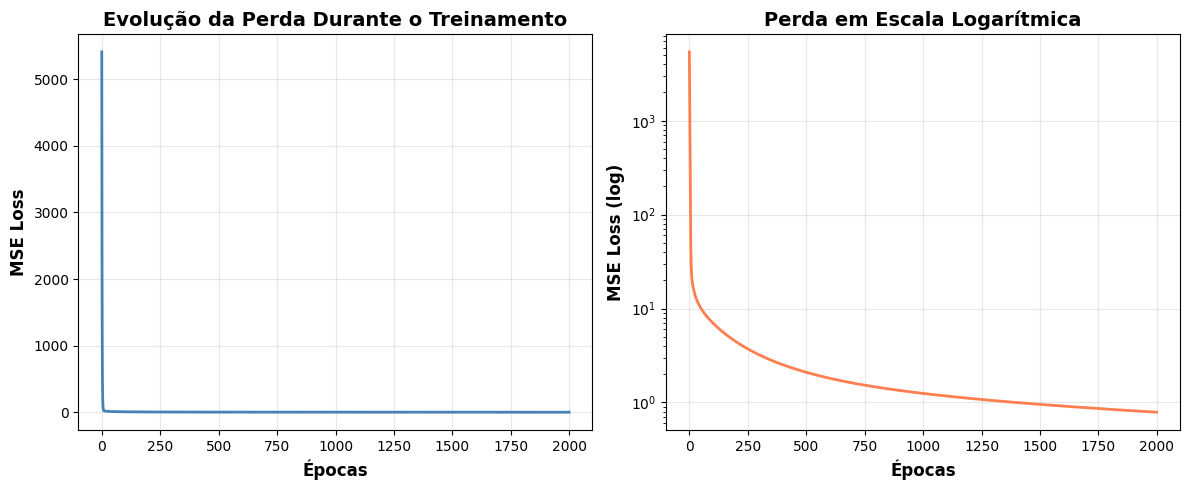

Loss inicial: 5409.7075
Loss final: 0.7871
Melhoria: 99.99%


In [11]:
plt.figure(figsize=(12, 5))

# Gráfico 1: Loss ao longo das épocas
plt.subplot(1, 2, 1)
plt.plot(loss_history, linewidth=2, color='steelblue')
plt.xlabel('Épocas', fontsize=12, fontweight='bold')
plt.ylabel('MSE Loss', fontsize=12, fontweight='bold')
plt.title('Evolução da Perda Durante o Treinamento', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Gráfico 2: Loss em escala logarítmica
plt.subplot(1, 2, 2)
plt.semilogy(loss_history, linewidth=2, color='coral')
plt.xlabel('Épocas', fontsize=12, fontweight='bold')
plt.ylabel('MSE Loss (log)', fontsize=12, fontweight='bold')
plt.title('Perda em Escala Logarítmica', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Loss inicial: {loss_history[0]:.4f}")
print(f"Loss final: {loss_history[-1]:.4f}")
print(f"Melhoria: {(loss_history[0] - loss_history[-1]) / loss_history[0] * 100:.2f}%")

## 6. Avaliação do Modelo

In [ ]:
# Predições
y_train_pred = model.forward(X_train)
y_test_pred = model.forward(X_test)

# Métricas de avaliação: R² e RMSE
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# R² Score
train_r2 = r2_score(YTrain, y_train_pred)
test_r2 = r2_score(YTest, y_test_pred)

# RMSE (Root Mean Squared Error)
train_mse = mean_squared_error(YTrain, y_train_pred)
test_mse = mean_squared_error(YTest, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("📊 MÉTRICAS DE AVALIAÇÃO")
print("="*60)
print(f"\n{'Métrica':<20} {'Treino':<20} {'Teste':<20}")
print("-"*60)
print(f"{'R² Score':<20} {train_r2:<20.6f} {test_r2:<20.6f}")
print(f"{'RMSE':<20} {train_rmse:<20.6f} {test_rmse:<20.6f}")
print("="*60)

# Interpretação
print(f"   R² Treino: {train_r2:.4f}")
print(f"   R² Teste:  {test_r2:.4f}")
print(f"\n   RMSE Treino: {train_rmse:.6f}")
print(f"   RMSE Teste:  {test_rmse:.6f}")
print(f"\n   Diferença R² (Treino - Teste): {abs(train_r2 - test_r2):.6f}")

📊 MÉTRICAS DE AVALIAÇÃO

Métrica              Treino               Teste               
------------------------------------------------------------
R² Score             0.992638             0.992559            
RMSE                 0.887014             0.891611            
   R² Treino: 0.9926 - Excelente
   R² Teste:  0.9926 - Excelente

   RMSE Treino: 0.887014 bpm
   RMSE Teste:  0.891611 bpm

   Diferença R² (Treino - Teste): 0.000079


## 7. Visualizar Predições vs Valores Reais

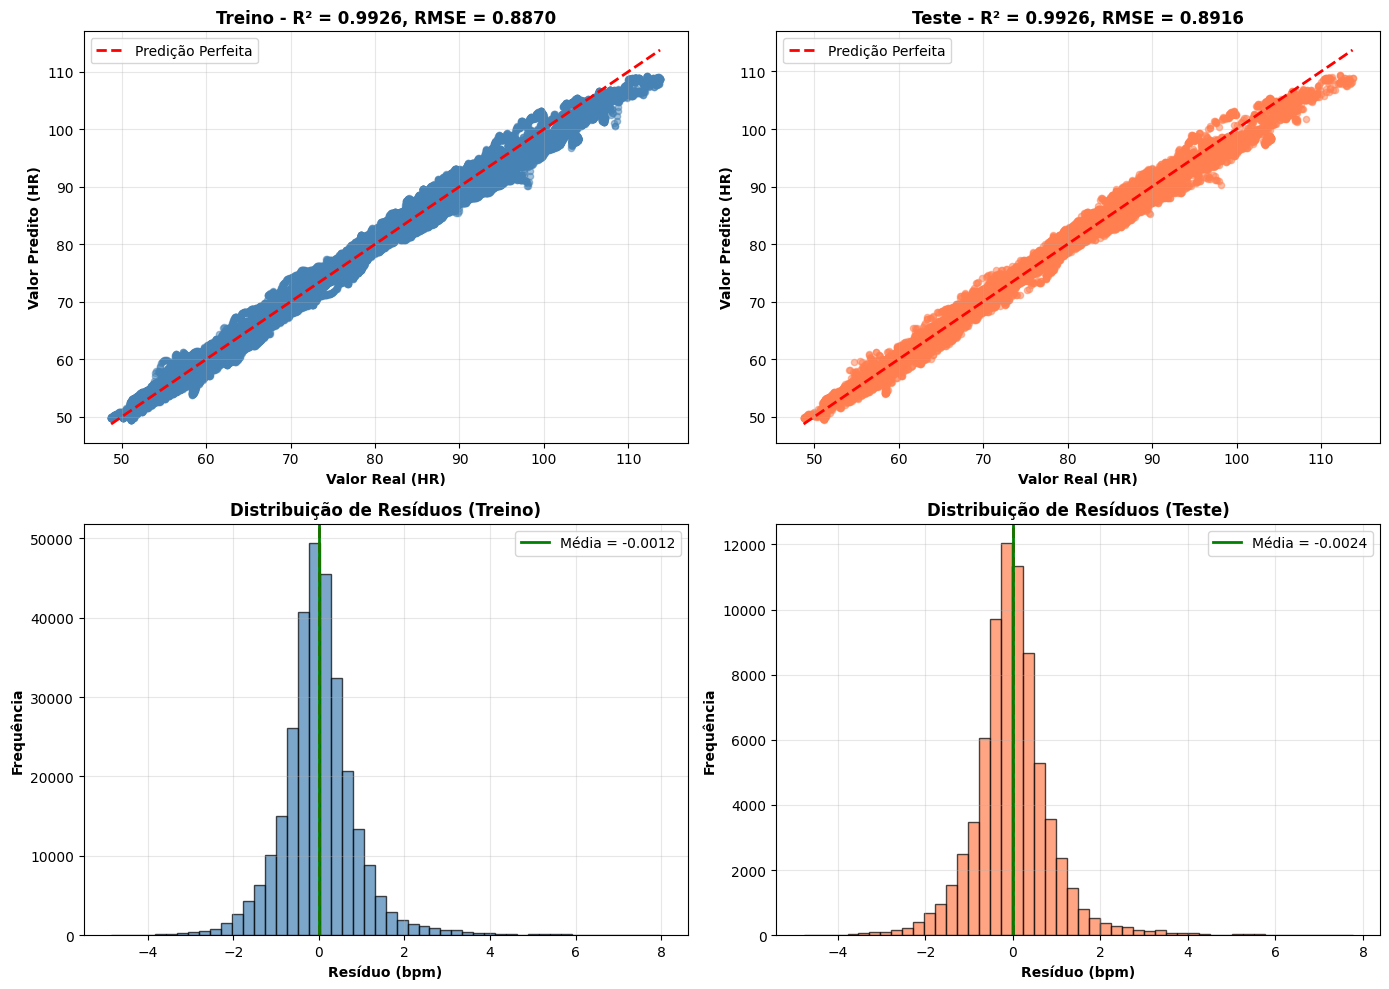

✅ Gráfico salvo: model_evaluation.png


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Predições vs Reais (Treino)
axes[0, 0].scatter(YTrain, y_train_pred, alpha=0.5, s=20, color='steelblue')
axes[0, 0].plot([YTrain.min(), YTrain.max()], [YTrain.min(), YTrain.max()], 
                 'r--', lw=2, label='Predição Perfeita')
axes[0, 0].set_xlabel('Valor Real (HR)', fontweight='bold')
axes[0, 0].set_ylabel('Valor Predito (HR)', fontweight='bold')
axes[0, 0].set_title(f'Treino - R² = {train_r2:.4f}, RMSE = {train_rmse:.4f}', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Predições vs Reais (Teste)
axes[0, 1].scatter(YTest, y_test_pred, alpha=0.5, s=20, color='coral')
axes[0, 1].plot([YTest.min(), YTest.max()], [YTest.min(), YTest.max()], 
                 'r--', lw=2, label='Predição Perfeita')
axes[0, 1].set_xlabel('Valor Real (HR)', fontweight='bold')
axes[0, 1].set_ylabel('Valor Predito (HR)', fontweight='bold')
axes[0, 1].set_title(f'Teste - R² = {test_r2:.4f}, RMSE = {test_rmse:.4f}', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Distribuição de Resíduos (Treino)
residuos_train = YTrain - y_train_pred
axes[1, 0].hist(residuos_train, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1, 0].axvline(residuos_train.mean(), color='g', linestyle='-', linewidth=2, label=f'Média = {residuos_train.mean():.4f}')
axes[1, 0].set_xlabel('Resíduo (bpm)', fontweight='bold')
axes[1, 0].set_ylabel('Frequência', fontweight='bold')
axes[1, 0].set_title('Distribuição de Resíduos (Treino)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Distribuição de Resíduos (Teste)
residuos_test = YTest - y_test_pred
axes[1, 1].hist(residuos_test, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axvline(residuos_test.mean(), color='g', linestyle='-', linewidth=2, label=f'Média = {residuos_test.mean():.4f}')
axes[1, 1].set_xlabel('Resíduo (bpm)', fontweight='bold')
axes[1, 1].set_ylabel('Frequência', fontweight='bold')
axes[1, 1].set_title('Distribuição de Resíduos (Teste)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico salvo: model_evaluation.png")

## 8. Análise de Exemplos

In [14]:
print("🎯 EXEMPLOS DE PREDIÇÕES (Conjunto de Teste)\n")
print(f"{'Índice':<10} {'Real':<12} {'Predito':<12} {'Erro Abs':<12} {'% Erro':<12}")
print("-"*58)

# Mostrar 10 exemplos aleatórios do conjunto de teste
indices = np.random.choice(len(YTest), 10, replace=False)
erros_percentuais = []

for idx in indices:
    real = YTest[idx][0]
    pred = y_test_pred[idx][0]
    erro_abs = abs(real - pred)
    erro_perc = (erro_abs / abs(real)) * 100 if real != 0 else 0
    erros_percentuais.append(erro_perc)
    print(f"{idx:<10} {real:<12.4f} {pred:<12.4f} {erro_abs:<12.4f} {erro_perc:<12.2f}%")

print("-"*58)
print(f"\n📊 ESTATÍSTICAS DOS ERROS:")
print(f"   Erro Absoluto Médio: {np.mean(np.abs(residuos_test)):.6f} bpm")
print(f"   Erro Percentual Médio: {np.mean(erros_percentuais):.2f}%")
print(f"   Mediana do Erro Percentual: {np.median(erros_percentuais):.2f}%")

🎯 EXEMPLOS DE PREDIÇÕES (Conjunto de Teste)

Índice     Real         Predito      Erro Abs     % Erro      
----------------------------------------------------------
14713      69.2358      69.5613      0.3255       0.47        %
27385      69.9350      68.6028      1.3322       1.90        %
22217      77.4660      77.3013      0.1647       0.21        %
47214      60.5851      60.6626      0.0776       0.13        %
49390      90.6331      88.0317      2.6015       2.87        %
13395      71.9131      73.2420      1.3290       1.85        %
314        77.6709      77.9623      0.2914       0.38        %
60362      79.8153      80.3049      0.4896       0.61        %
73393      58.8195      58.2701      0.5495       0.93        %
42253      75.6876      75.4711      0.2165       0.29        %
----------------------------------------------------------

📊 ESTATÍSTICAS DOS ERROS:
   Erro Absoluto Médio: 0.617773 bpm
   Erro Percentual Médio: 0.96%
   Mediana do Erro Percentual: 0.54%


## 9. Salvar o Modelo Treinado

In [15]:
# Salvar o modelo treinado
import os

# Criar diretório para modelos
modelos_dir = 'modelos_treinados'
if not os.path.exists(modelos_dir):
    os.makedirs(modelos_dir)
    print(f"✅ Diretório '{modelos_dir}' criado")

# Salvar o modelo
modelo_path = f'{modelos_dir}/modelo_hr_prediction.npz'
model.save_model(modelo_path)

# Obter informações do modelo
info = model.get_model_info()

print("\n📊 INFORMAÇÕES DO MODELO SALVO")
print("="*50)
print(f"{'Parâmetro':<25} {'Valor':<25}")
print("-"*50)
print(f"{'Camada de entrada':<25} {info['input_size']:<25}")
print(f"{'Camada oculta':<25} {info['hidden_size']:<25}")
print(f"{'Camada de saída':<25} {info['output_size']:<25}")
print(f"{'Weight Decay (L2)':<25} {info['weight_decay']:<25}")
print(f"{'Total de parâmetros':<25} {info['total_params']:<25}")
print("="*50)
print(f"\n📁 Arquivo salvo em: {modelo_path}")
print(f"   Tamanho: {os.path.getsize(modelo_path) / 1024:.2f} KB")

✅ Modelo salvo com sucesso em: modelos_treinados/modelo_hr_prediction.npz
   Tamanho do arquivo: Save several arrays into a single file in uncompressed ``.npz`` format.

    Provide arrays as keyword arguments to store them under the
    corresponding name in the output file: ``savez(fn, x=x, y=y)``.

    If arrays are specified as positional arguments, i.e., ``savez(fn,
    x, y)``, their names will be `arr_0`, `arr_1`, etc.

    Parameters
    ----------
    file : file, str, or pathlib.Path
        Either the filename (string) or an open file (file-like object)
        where the data will be saved. If file is a string or a Path, the
        ``.npz`` extension will be appended to the filename if it is not
        already there.
    args : Arguments, optional
        Arrays to save to the file. Please use keyword arguments (see
        `kwds` below) to assign names to arrays.  Arrays specified as
        args will be named "arr_0", "arr_1", and so on.
    allow_pickle : bool, optional

In [16]:
# Teste: Carregar o modelo salvo e fazer predições
print("🧪 TESTE DE CARREGAMENTO DO MODELO\n")

# Carregar o modelo salvo
modelo_carregado = NeuralNetworkRegression.load_model(modelo_path)

# Obter informações
info_carregado = modelo_carregado.get_model_info()

print("\n📊 Comparação: Modelo Original vs Carregado")
print("="*50)
info_original = model.get_model_info()

for key in info_original.keys():
    original = info_original[key]
    carregado = info_carregado[key]
    match = "✅" if original == carregado else "❌"
    print(f"{match} {key:<25}: {original} → {carregado}")

print("="*50)

# Fazer predições com o modelo carregado
y_test_pred_carregado = modelo_carregado.forward(X_test)

# Comparar com predições do modelo original
diff = np.abs(y_test_pred - y_test_pred_carregado).max()
print(f"\n✅ Máxima diferença nas predições: {diff:.2e}")
print(f"   (Deve estar próximo de 0 - confirma que o modelo foi carregado corretamente)")

# Exemplo de predição com o modelo carregado
print(f"\n🎯 Exemplo de Predição (usando modelo carregado):")
idx_exemplo = 0
print(f"   Real: {YTest[idx_exemplo][0]:.4f}")
print(f"   Predito (original): {y_test_pred[idx_exemplo][0]:.4f}")
print(f"   Predito (carregado): {y_test_pred_carregado[idx_exemplo][0]:.4f}")

🧪 TESTE DE CARREGAMENTO DO MODELO

✅ Modelo carregado com sucesso de: modelos_treinados/modelo_hr_prediction.npz
   Arquitetura: 35 → 128 → 1
   Weight Decay: 0.0

📊 Comparação: Modelo Original vs Carregado
✅ input_size               : 35 → 35
✅ hidden_size              : 128 → 128
✅ output_size              : 1 → 1
✅ weight_decay             : 0.0 → 0.0
✅ total_params             : 4737 → 4737

✅ Máxima diferença nas predições: 0.00e+00
   (Deve estar próximo de 0 - confirma que o modelo foi carregado corretamente)

🎯 Exemplo de Predição (usando modelo carregado):
   Real: 86.3149
   Predito (original): 85.3024
   Predito (carregado): 85.3024


## 10. Carregar e Usar o Modelo Salvo

### Como carregar o modelo em outro notebook

```python
from neural_network import NeuralNetworkRegression

# Carregar o modelo
modelo_carregado = NeuralNetworkRegression.load_model('modelos_treinados/modelo_hr_prediction.npz')

# Fazer predições com novos dados
X_novo = ...  # seus dados processados
predicoes = modelo_carregado.forward(X_novo)

# Obter informações do modelo
info = modelo_carregado.get_model_info()
print(f"Arquitetura: {info['input_size']} → {info['hidden_size']} → {info['output_size']}")
```